In [3]:
import h5py 
import numpy as np 
import matplotlib.pyplot as plt 
from scipy import stats 
from extra_data import RunDirectory 
import scipy
%matplotlib widget

In [4]:
import xarray

def read_run_sync_trains(r, verbose=True):
    #clear_output(wait=False) 
    #sys.stderr.write(f'Processing run {r}...\n') 
    run = RunDirectory(path='/pnfs/xfel.eu/exfel/archive/XFEL/raw/SPB/202202/p003046/r%04d' % (r))  
    
    # The require_all=True ensures we only get trains which exist for all sources
    sel = run.select([
        ('SPB_XTD9_XGM/XGM/DOOCS:output', 'data.intensitySa1TD'),
        ('SA1_XTD2_XGM/XGM/DOOCS:output', 'data.intensitySa1TD'),
        ('SPB_IRU_MOTORS/MDL/DATA_SELECT', '*'),
        ('SPB_EXP_ZYLA/CAM/1:daqOutput', 'data.image.pixels'),
        ('SPB_IRU_LIQUIDJET/FLOW/BRONKHORST_SAMPLE2','measureCapacity.value'),
        ('SPB_IRU_LIQUIDJET/FLOW/BRONKHORST_WASH1','measureCapacity.value'),
        ('SPB_IRU_LIQUIDJET/FLOW/BRONKHORST_1','measureCapacity.value'),
    ], require_all=True)
    if(verbose):
        sel.info()
    
    intensity_sase1_extra = sel['SPB_XTD9_XGM/XGM/DOOCS:output', 'data.intensitySa1TD']
    intensity_preattenuator_sase1_extra = sel['SA1_XTD2_XGM/XGM/DOOCS:output', 'data.intensitySa1TD']    
    motors_x_extra = sel['SPB_IRU_MOTORS/MDL/DATA_SELECT', 'SPB_IRU_INJMOV_MOTOR_X.actualPosition.value']
    motors_y_extra = sel['SPB_IRU_MOTORS/MDL/DATA_SELECT', 'SPB_IRU_INJMOV_MOTOR_Y.actualPosition.value']

    # Put the data in xarray
    motor_x = motors_x_extra.xarray()
    motor_y = motors_y_extra.xarray()
    xgm = intensity_sase1_extra.xarray()
    xgm2 = intensity_preattenuator_sase1_extra.xarray()
    if r < 100:
        liquid_flow = sel['SPB_IRU_LIQUIDJET/FLOW/BRONKHORST_WASH1','measureCapacity.value'].xarray()
    else:
        liquid_flow = sel['SPB_IRU_LIQUIDJET/FLOW/BRONKHORST_SAMPLE2','measureCapacity.value'].xarray()
    gas_flow = sel['SPB_IRU_LIQUIDJET/FLOW/BRONKHORST_1','measureCapacity.value'].xarray()
    
    directory = '/gpfs/exfel/u/scratch/SPB/202202/p003046/data' 
    agipd_frames_per_train = 202 # number of agipd frames per train
    with h5py.File(directory+'/r%04d_proc_radavg.h5' % (r)) as rad: 
        radavg = rad['entry_1']['radialavg'][:]
        trainIds = rad['entry_1']['trainId'][:]
        q = rad['entry_1']['q'][:]
    
    # Reshape the arrays from the radavg file to make them by train
    radavg = radavg.reshape((-1,agipd_frames_per_train,radavg.shape[1]))
    trainIds = trainIds.reshape((-1,agipd_frames_per_train))
    # Ensure all the trains are the same length
    if (trainIds == trainIds[:,:1]).all() != True:
        raise ValueError        
    if(verbose):
        print("Reshaping of radavg successful:", (trainIds == trainIds[:,:1]).all())
    trainIds = trainIds[:,0]
    
    # Put radavg in an xarray
    radavg = xarray.DataArray(data=radavg, dims=('trainId', 'pulseNr', 'q'), 
                              coords={'trainId': trainIds, 'pulseNr': np.arange(agipd_frames_per_train), 'q': q})

    # Find trains which are common between radavg and the rest
    common_trains = np.intersect1d(intensity_sase1_extra.train_id_coordinates(), trainIds)
    if verbose:
        print("Found %d common train IDs between radavg and the rest" % len(common_trains))

    # Find the indices of the common trainIds and keep only those
    common_train_idx = np.searchsorted(intensity_sase1_extra.train_id_coordinates(),common_trains)
    motor_x = motor_x[common_train_idx]
    motor_y = motor_y[common_train_idx]
    xgm = xgm[common_train_idx]
    liquid_flow[common_train_idx]
    gas_flow[common_train_idx]

    # Find the indices of the common trainIds for radavg    
    common_train_idx = np.searchsorted(radavg.coords['trainId'].data,common_trains)
    radavg = radavg[common_train_idx]
    
    train_ids_eq = (motor_x.coords['trainId'].data == radavg.coords['trainId'].data)
    if verbose:
        print("Train IDs all match:", train_ids_eq.all())
    
    return xgm, motor_x, motor_y, radavg, xgm2, liquid_flow, gas_flow

In [5]:

def sync_pulses(xgm, radavg, xgm2):
    # Find out how many X-ray pulses per train

    npulses = np.sum(np.nanmean(xgm,axis=0) > 1.0)
    # For certain runs we actually receive more than 176 pulses, but the agipd will only record 176   
    npulses = min(npulses,176)
    agipd_frames_per_pulse = 176//npulses
    return xgm[:,:npulses], radavg[:,1:npulses*agipd_frames_per_pulse+1:agipd_frames_per_pulse,:], xgm2[:,:npulses]

In [6]:
def integrate_q_range(radavg, q_min = 0.73, q_max = 13, verbose=True):
    # q_min and q_max in 1/nm

    q = radavg.coords['q'].data
    q_min_idx = np.argmax(q > q_min)
    q_max_idx = np.argmax(q > q_max)
    
    if(verbose):
        print('Integrating between %g-%g 1/nm' % (q_min,q_max))   
    I = xarray.DataArray(data=np.nansum(radavg[:,:,q_min_idx:q_max_idx],axis=2), dims=('trainId', 'pulseNr'), coords={'trainId': radavg.coords['trainId'], 'pulseNr': radavg.coords['pulseNr']})
    return I

In [7]:
def combine_runs(runs, verbose=False):
    comb_xgm = None
    comb_motor_x = None
    comb_motor_y = None
    comb_radavg = None
    comb_xgm2 = None
    comb_I = None
    comb_R2 = None
    comb_slopes = None
    comb_liquid_flow = None
    comb_gas_flow = None
    for run in runs:
        xgm, motor_x, motor_y, radavg, xgm2, liquid_flow, gas_flow = read_run_sync_trains(run, verbose=verbose)
        xgm, radavg, xgm2 = sync_pulses(xgm, radavg, xgm2)
        I = integrate_q_range(radavg, verbose=False)
        
        if comb_I is None:
            comb_I = I
            comb_liquid_flow = liquid_flow
            comb_gas_flow = gas_flow
        else:
            comb_I = xarray.concat((comb_I, I),'trainId')
            comb_liquid_flow = xarray.concat((comb_liquid_flow, liquid_flow),'trainId')
            comb_gas_flow = xarray.concat((comb_gas_flow, gas_flow),'trainId')

        if comb_xgm is None:
            comb_xgm = xgm
        else:
            comb_xgm = xarray.concat((comb_xgm, xgm),'trainId')            

    return comb_xgm, comb_I, comb_liquid_flow, comb_gas_flow

In [9]:
def linear_fit_trains(xgm, I, n=1, xgm_min = 0):
    # Do a linear fit of the intensity I versus the xgm, n consecutive trains at a time
    # The default is to do one train at a time (n=1)
    slopes = np.zeros(int(np.ceil(xgm.shape[0]/n)))
    intercept = np.zeros(int(np.ceil(xgm.shape[0]/n)))
    R2 = np.zeros(int(np.ceil(xgm.shape[0]/n)))
    RelError = np.zeros(int(np.ceil(xgm.shape[0]/n)))
    Pearson_R = np.zeros(int(np.ceil(xgm.shape[0]/n)))
    
    for i,idx in enumerate(np.arange(0,xgm.shape[0],n)):
        x = np.ravel(xgm.data[idx:idx+n])
        y = np.ravel(I.data[idx:idx+n])
        # Only take points with XGM > xgm_min uJ
        mask = x > xgm_min
        x = x[mask]
        y = y[mask]
        # Only take shots with more than 1500 uJ
        fit = stats.linregress(x, y)

                 
        slopes[i] = fit.slope
        intercept[i] = fit.intercept
        R2[i] = fit.rvalue**2
        fit_values = x*fit.slope + fit.intercept
        RelError[i] = np.nanmean(np.abs((y - fit_values)/fit_values))
    return slopes, intercept, R2, RelError

In [10]:
comb_xgm, comb_I, comb_liquid_flow, comb_gas_flow = combine_runs([84,85,86], verbose=True)

# of trains:    3113
Duration:       0:05:12.7
First train ID: 1473643718
Last train ID:  1473646844

0 detector modules ()

3 instrument sources (excluding detectors):
  - SA1_XTD2_XGM/XGM/DOOCS:output
  - SPB_EXP_ZYLA/CAM/1:daqOutput
  - SPB_XTD9_XGM/XGM/DOOCS:output

4 control sources:
  - SPB_IRU_LIQUIDJET/FLOW/BRONKHORST_1
  - SPB_IRU_LIQUIDJET/FLOW/BRONKHORST_SAMPLE2
  - SPB_IRU_LIQUIDJET/FLOW/BRONKHORST_WASH1
  - SPB_IRU_MOTORS/MDL/DATA_SELECT

Reshaping of radavg successful: True
Found 3113 common train IDs between radavg and the rest
Train IDs all match: True
# of trains:    3123
Duration:       0:05:12.6
First train ID: 1473646979
Last train ID:  1473650104

0 detector modules ()

3 instrument sources (excluding detectors):
  - SA1_XTD2_XGM/XGM/DOOCS:output
  - SPB_EXP_ZYLA/CAM/1:daqOutput
  - SPB_XTD9_XGM/XGM/DOOCS:output

4 control sources:
  - SPB_IRU_LIQUIDJET/FLOW/BRONKHORST_1
  - SPB_IRU_LIQUIDJET/FLOW/BRONKHORST_SAMPLE2
  - SPB_IRU_LIQUIDJET/FLOW/BRONKHORST_WASH1
  - S

In [11]:
comb_xgm_lj, comb_I_lj, comb_liquid_flow_lj, comb_gas_flow_lj = combine_runs([195,196], verbose=True)


# of trains:    3109
Duration:       0:05:12.7
First train ID: 1475340148
Last train ID:  1475343274

0 detector modules ()

3 instrument sources (excluding detectors):
  - SA1_XTD2_XGM/XGM/DOOCS:output
  - SPB_EXP_ZYLA/CAM/1:daqOutput
  - SPB_XTD9_XGM/XGM/DOOCS:output

4 control sources:
  - SPB_IRU_LIQUIDJET/FLOW/BRONKHORST_1
  - SPB_IRU_LIQUIDJET/FLOW/BRONKHORST_SAMPLE2
  - SPB_IRU_LIQUIDJET/FLOW/BRONKHORST_WASH1
  - SPB_IRU_MOTORS/MDL/DATA_SELECT

Reshaping of radavg successful: True
Found 3109 common train IDs between radavg and the rest
Train IDs all match: True
# of trains:    1045
Duration:       0:01:44.5
First train ID: 1475343409
Last train ID:  1475344453

0 detector modules ()

3 instrument sources (excluding detectors):
  - SA1_XTD2_XGM/XGM/DOOCS:output
  - SPB_EXP_ZYLA/CAM/1:daqOutput
  - SPB_XTD9_XGM/XGM/DOOCS:output

4 control sources:
  - SPB_IRU_LIQUIDJET/FLOW/BRONKHORST_1
  - SPB_IRU_LIQUIDJET/FLOW/BRONKHORST_SAMPLE2
  - SPB_IRU_LIQUIDJET/FLOW/BRONKHORST_WASH1
  - S

In [12]:
# Skip the first 1500 trains as there's a step change (in position)
comb_xgm_lj =comb_xgm_lj[1500:]
comb_I_lj =comb_I_lj[1500:]
comb_liquid_flow_lj =comb_liquid_flow_lj[1500:]
comb_gas_flow_lj =comb_gas_flow_lj[1500:]

In [13]:
# Make sure the two runs are of the same size
comb_xgm = comb_xgm[:comb_xgm_lj.shape[0]]
comb_I = comb_I[:comb_I_lj.shape[0]]
comb_liquid_flow = comb_liquid_flow[:comb_liquid_flow_lj.shape[0]]
comb_gas_flow = comb_gas_flow[:comb_gas_flow_lj.shape[0]]

FileNotFoundError: [Errno 2] No such file or directory: '../figures/S1_xgm_normalized_I_50_trains.pdf'

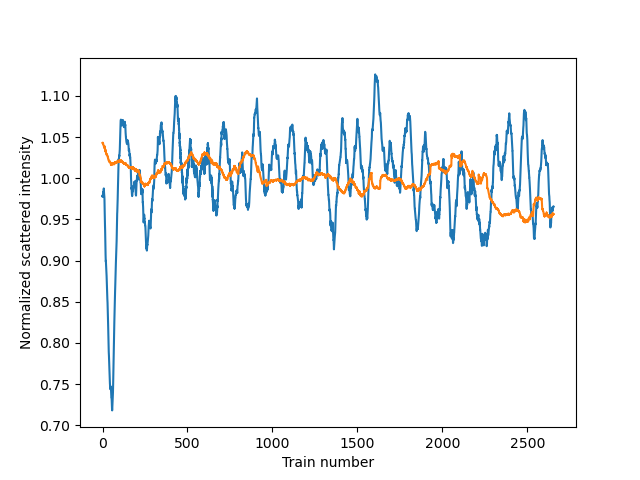

In [14]:
import scipy.ndimage
plt.figure()
scale = 1.0/(np.mean(comb_I.data)/np.mean(comb_xgm.data))
scale_lj = 1.0/(np.mean(comb_I_lj)/np.mean(comb_xgm_lj))
npulses = len(comb_I.data.flatten())
plt.plot(np.linspace(0,npulses//176, npulses),scale*scipy.ndimage.uniform_filter1d(comb_I.data.flatten()/comb_xgm.data.flatten(), size=50*comb_I.shape[1]))
plt.plot(np.linspace(0,npulses//176, npulses),float(scale_lj)*scipy.ndimage.uniform_filter1d(comb_I_lj.data.flatten()/comb_xgm_lj.data.flatten(), size=50*comb_I.shape[1]))
plt.xlabel('Train number')
plt.ylabel('Normalized scattered intensity')
plt.savefig('../figures/S1_xgm_normalized_I_50_trains.pdf')
plt.plot()


FileNotFoundError: [Errno 2] No such file or directory: '../figures/2a_xgm_normalized_I.pdf'

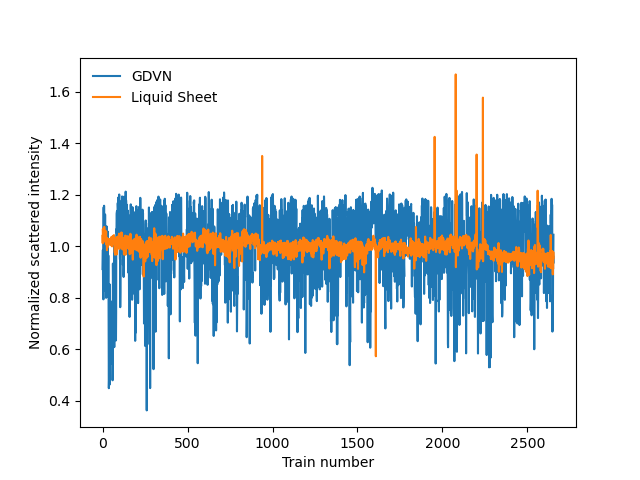

In [15]:
import scipy.ndimage
plt.figure()


plt.plot(scale*np.mean(comb_I.data, axis=1)/np.mean(comb_xgm.data, axis=1), label='GDVN')
plt.plot(scale_lj*np.mean(comb_I_lj, axis=1)/np.mean(comb_xgm_lj, axis=1), label='Liquid Sheet')
plt.legend(frameon=False)
#plt.plot(np.mean(comb_xgm_lj, axis=1))
#plt.plot(np.mean(comb_xgm, axis=1))
plt.xlabel('Train number')
plt.ylabel('Normalized scattered intensity')
plt.savefig('../figures/2a_xgm_normalized_I.pdf')
plt.plot()
print("Standard deviation of GDVN signal - %f" % (np.std(scale*np.mean(comb_I.data, axis=1)/np.mean(comb_xgm.data, axis=1))))
print("Standard deviation of Liquid Sheet signal - %f" % (np.std(scale_lj*np.mean(comb_I_lj, axis=1)/np.mean(comb_xgm_lj, axis=1))))